In [1]:
import pandas as pd
from statsmodels.stats.proportion import proportion_confint as ci
from natsort import natsorted
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def get_clean_cape_dataframe(filepath):
    """
    read the cleaned data as dataframe
    Args:
        filepath: str
        the location of the csv file
    Returns:
        dataframe
    """
    df = pd.read_csv(filepath)
    return df

In [3]:
def get_depts_and_courses_dictionary(df):
    """
    get all courses for departments
    Args:
        df: dataframe

    Returns:
        depths_courses: dict

    Examples:
    --------
        >>> df = get_clean_cape_dataframe(filepath)
        >>> get_depts_and_courses_dictionary(df)
        depths_courses = {'AAS': ['10', '11', '170', '190'], 'ANAR': ['100', '114', '115', '116', '135', '135S', '143']}

    """
    df = (df['Course_ID'].str.split(expand=True)
          .rename(columns={0: 'dept', 1: 'course'})
          .drop_duplicates())

    depts = natsorted(df.dept.unique())
    df = df.set_index(['dept', 'course']).sort_index()

    depts_courses = {dept: natsorted(df.loc[dept].index) for dept in depts}

    return depts_courses

In [4]:
def get_time_df(df):
    """
    group the dataframe using the Course_ID, the average spending time for a particular course between different terms is calculated
    compare the time with other courses
    Args:
        df
    Returns:
        gb: dataframe

    Examples:
    --------
        >>> df = get_clean_cape_dataframe(filepath)
        >>> get_time_dictionary(df)
           
        new_df:
            Course_ID  time  depart_avg_time  global_avg_time  depart_time_diff  global_time_diff              
        0       AAS 10  4.07             3.75         5.494174              0.32         -1.424174
        1      AAS 170  3.61             3.75         5.494174             -0.14         -1.884174  
        2      AAS 190  2.93             3.75         5.494174             -0.82         -2.564174  
        3     ANAR 100  3.17             4.10         5.494174             -0.93         -2.324174  
        4     ANAR 116  3.59             4.10         5.494174             -0.51         -1.904174  
    """

    df = df[['Course_ID', 'time']]
    # groupby to get average time for same courses in different quarters
    gb = df[['time', 'Course_ID']].groupby('Course_ID').mean().round(2)
    # print(gb)

    # for departments
    depths_time = {}
    depths_courses = get_depts_and_courses_dictionary(df)
    for dept, courses in depths_courses.items():
        times = []
        for course in courses:
            mask = df['Course_ID'].str.startswith(dept + ' ' + course)
            if mask.any():
                times.extend(df.loc[mask, 'time'])

        if times:
            average_time = np.mean(times)
            std_deviation = np.std(times)
            depths_time[dept] = (average_time, std_deviation)

    # for all courses
    global_average = float(gb.mean())
    global_sd = float(gb.std())

    df['department'] = df['Course_ID'].str.split().str[0]
    df['depart_avg_time'] = df['department'].map(lambda x: depths_time[x][0] if x in depths_time else None)

    gb = df.groupby('Course_ID').mean().round(2).reset_index()
    gb['global_avg_time'] = global_average
    gb['depart_time_diff'] = gb['time'] - gb['depart_avg_time']
    gb['global_time_diff'] = gb['time'] - global_average

    return gb

In [5]:
def get_grade_dev_df(df):
    """
    group the dataframe using the Course_ID, the average expected and actual gpa for a particular course between different terms is calculated
    compare the expected gpa and actual gpa
    Args:
        df
    Returns:
        gb: dataframe

    Examples:
    --------
        >>> df = get_clean_cape_dataframe(filepath)
        >>> get_grade_dictionary(df)

        new_df:
                Course_ID  expected_gpa  actual_gpa   dev
            0       AAS 10          3.79        3.56 -0.23
            1      AAS 170          3.89        3.68 -0.21
            2      AAS 190          3.86        4.00  0.14
            3     ANAR 100          3.33        3.30 -0.03
            4     ANAR 116          3.70        3.35 -0.35
            ...        ...           ...         ...   ...
            1205   VIS 70N          3.78        3.60 -0.18
            1206    VIS 80          3.84        3.82 -0.02
            1207  WCWP 100          3.54        3.49 -0.05
            1208  WCWP 10A          3.73        3.65 -0.08
            1209  WCWP 10B          3.55        3.50 -0.05
                            
    """
    df = df[['Course_ID', 'expected_gpa', 'actual_gpa']]

    # groupby to get the mean grade and round to 2 decimal places
    gb = df.groupby('Course_ID').mean().round(2).reset_index()
    gb['dev'] = gb['actual_gpa'] - gb['expected_gpa']

    return gb


In [6]:
def get_class_rmd_df(df):
    """
    group the dataframe using the Course_ID, the average class recommendation ratio for a particular course between different terms is calculated
    Args:
        df
    Returns:
        gb: dataframe

    Examples:
    --------
        >>> df = get_clean_cape_dataframe(filepath)
        >>> get_class_rmd_df(df)

        new_df:
             Course_ID  rmd_class
        0       AAS 10      85.68
        1       AAS 11      93.50
        2      AAS 170      94.45
        3      AAS 190     100.00
        4     ANAR 100     100.00
        ...        ...        ...
        2447    VIS 84      80.55
        2448     VIS 9      80.60
        2449  WCWP 100      92.66
        2450  WCWP 10A      91.66
        2451  WCWP 10B      90.33
    """
    df = df[['Course_ID', 'rmd_class']]
    # groupby to get the mean course recommendation ratio and round to 2 decimal places
    gb = df.groupby(['Course_ID']).mean().round(2).reset_index()
    
    return gb

In [7]:
def get_instr_rmd_df(df):
    """
    group the dataframe using the Course_ID, the average instructor recommendation ratio for a particular course between different terms is calculated
    Args:
        df
    Returns:
        gb: dataframe

    Examples:
    --------
        >>> df = get_clean_cape_dataframe(filepath)
        >>> get_instr_rmd_df(df):

        new_df:
                Course_ID                        instr  rmd_instr
        0       AAS 10    Butler, Elizabeth Annette      88.63
        1      AAS 170    Butler, Elizabeth Annette      88.90
        2      AAS 190  Puritty, Chandler Elizabeth     100.00
        3     ANAR 100                Fortier, Jana     100.00
        4     ANAR 116            Shtienberg, Gilad     100.00
        ...        ...                          ...        ...
        2256  WCWP 10A              Savage, Sarah S     100.00
        2257  WCWP 10A                Susi, Natalie      97.10
        2258  WCWP 10B            Gagnon, Jeffrey C      95.80
        2259  WCWP 10B           Tocki, Jasmine Rae     100.00
        2260  WCWP 10B         Welji, Haleema Nazir      93.30
    """
    df = df[['Course_ID', 'instr', 'rmd_instr']]

    # groupby to get the mean grade and round to 2 decimal places
    gb = df.groupby(['Course_ID','instr']).mean().round(2).reset_index()
    
    return gb

In [8]:
df = get_clean_cape_dataframe('data_clean.csv')

In [9]:
df

,instr,term,enroll,evals,rmd_class,rmd_instr,time,Course_ID,Course_Name,expected_grade,expected_gpa,actual_grade,actual_gpa
0,"Butler, Elizabeth Annette",SP23,66,48,93.5,100.0,2.80,AAS 10,Intro/African-American Studies (A),A-,3.84,B+,3.67
1,"Butler, Elizabeth Annette",SP23,20,7,100.0,100.0,2.50,AAS 170,Legacies of Research (A),A-,3.86,A-,3.92
2,"Shtienberg, Gilad",SP23,26,6,100.0,83.3,3.83,ANAR 115,Coastal Geomorphology/Environ (A),B+,3.50,B,3.07
3,"Braswell, Geoffrey E.",SP23,22,9,100.0,100.0,5.17,ANAR 155,Stdy Abrd: Ancient Mesoamerica (A),A,4.00,A,4.00
4,"Hrvoj Mihic, Branka",SP23,22,4,100.0,100.0,2.50,ANBI 111,Human Evolution (A),A,4.00,B-,2.95
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15400,"Blomstedt, Elizabeth Ann",SP19,20,6,100.0,100.0,4.50,WCWP 100,Academic Writing (B),B+,3.60,B+,3.42
15401,"McCleary, Keith Long",SP19,20,19,84.2,94.4,8.39,WCWP 100,Academic Writing (C),B-,2.95,B,3.17
15402,"Young, Mark T",SP19,20,8,75.0,87.5,8.00,WCWP 100,Academic Writing (F),B,3.13,B+,3.34
15403,"Gagnon, Jeffrey C",SP19,150,126,76.9,91.5,5.21,WCWP 10A,The Writing Course A (0),B,3.11,B,3.21


In [10]:
#Out of 10 how much do you care about each category
#(GPA, Time Spent, Exp vs True GPA, %Rec Course, % Rec Prof)
# Ex [10, 10, 5, 5, 5]
ratings = [10, 10, 5, 5, 5]

In [11]:
def weights(ratings):
    '''
    Calculate weights based on rankings
    '''
    weights = []
    for i in ratings:
        weights.append(i/sum(ratings))
    return weights
        

In [12]:
weights = weights(ratings)
print(weights)

[0.2857142857142857, 0.2857142857142857, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285]


In [13]:
#Input the desired quarters
# 1:Fall
# 2:Winter
# 3:Spring
# 4:Summer Session 1
# 5:Summer Session 2
# Ex [1,2,3] will select Fall, Winter ,and Spring


In [14]:
quarters = list(map(int, input().split(' ')))

1


In [15]:
print(quarters)

[1]


In [16]:
enum = {1: 'FA', 2:'WI', 3:'SP', 4: 'S1', 5:'S2'}
# taken FA as an example
df_quarter = df[df['term'].str.contains('FA')].reset_index(drop=True)  # should change for later

In [17]:
df_quarter

,instr,term,enroll,evals,rmd_class,rmd_instr,time,Course_ID,Course_Name,expected_grade,expected_gpa,actual_grade,actual_gpa
0,"Butler, Elizabeth Annette",FA22,69,20,70.0,75.0,3.70,AAS 10,Intro/African-American Studies (A),A-,3.93,A-,3.80
1,"Butler, Elizabeth Annette",FA22,31,9,88.9,88.9,3.61,AAS 170,Legacies of Research (A),A-,3.89,B+,3.68
2,"Fortier, Jana",FA22,20,3,100.0,100.0,3.17,ANAR 100,Spec Topics/Anth Archaeology (A),B+,3.33,B+,3.30
3,"Goldstein, Paul S",FA22,25,8,100.0,100.0,1.36,ANAR 143,Biblical Arch- Fact or Fiction (A),A-,3.86,A-,3.85
4,"Marchetto, Maria Carolina",FA22,30,14,100.0,100.0,1.93,ANBI 100,Special Topic/Biological Anth (A),A,4.00,A-,3.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4194,"Cho, Erica",FA19,127,78,81.6,70.7,6.47,VIS 70N,Introduction to Media (A),B+,3.64,B+,3.59
4195,"Tonies, Joshua Vanjaymes",FA19,115,96,97.9,98.9,9.43,VIS 80,Introduction to Studio Major (A),B+,3.67,B+,3.65
4196,"McCleary, Keith Long",FA19,20,20,95.0,100.0,8.70,WCWP 100,Academic Writing (B),B,3.00,B,3.28
4197,"Gagnon, Jeffrey C",FA19,697,398,74.3,86.9,4.77,WCWP 10A,The Writing Course A (0),B+,3.39,B,3.28


In [18]:
# Input the desired department

# Taken ECE as an example
# 1. if no specific class is chosen

In [19]:
# factor 1: Time spent
time_factor = get_time_df(df_quarter)
time_factor_depart = time_factor[time_factor['Course_ID'].str.contains('ECE')].copy().reset_index(drop=True) # should change for later
print(time_factor_depart)

   Course_ID   time  depart_avg_time  global_avg_time  depart_time_diff  \
0    ECE 100   9.25             8.89         5.494174              0.36   
1    ECE 101   9.16             8.89         5.494174              0.27   
2    ECE 102   8.30             8.89         5.494174             -0.59   
3    ECE 103   6.60             8.89         5.494174             -2.29   
4    ECE 107   7.72             8.89         5.494174             -1.17   
5    ECE 109   7.20             8.89         5.494174             -1.69   
6    ECE 111   7.48             8.89         5.494174             -1.41   
7   ECE 121A   8.90             8.89         5.494174              0.01   
8   ECE 128A   5.99             8.89         5.494174             -2.90   
9   ECE 135A   4.75             8.89         5.494174             -4.14   
10   ECE 143   7.44             8.89         5.494174             -1.45   
11   ECE 144  10.99             8.89         5.494174              2.10   
12   ECE 148  15.07      

/var/folders/p2/9qv37hs10bb0jp9zgx1x51v00000gn/T/ipykernel_37912/1136106858.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['department'] = df['Course_ID'].str.split().str[0]
/var/folders/p2/9qv37hs10bb0jp9zgx1x51v00000gn/T/ipykernel_37912/1136106858.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['depart_avg_time'] = df['department'].map(lambda x: depths_time[x][0] if x in depths_time else None)


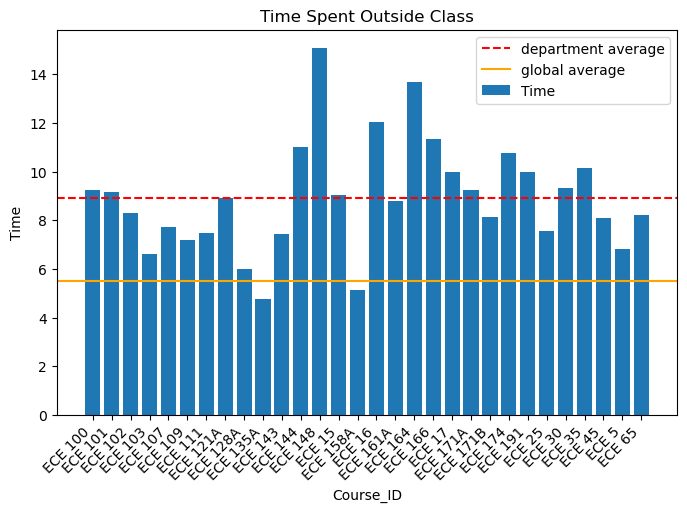

In [20]:
time_draw = time_factor_depart 

plt.figure(figsize=(8, 5))
plt.bar(time_draw['Course_ID'], time_draw['time'], label='Time')

depart_average_time = time_draw['time'].mean()
plt.axhline(y=depart_average_time, color='red', linestyle='--', label='department average')

global_average_time = time_draw['global_avg_time'].mean()
plt.axhline(y=global_average_time, color='orange', linestyle='-', label='global average')

plt.title('Time Spent Outside Class')
plt.xlabel('Course_ID')
plt.ylabel('Time')

plt.xticks(rotation=45, ha='right')

plt.legend()
plt.show()

In [21]:
# factor 2: difference between actual gpa and expected gpa
grade_dev_factor = get_grade_dev_df(df_quarter)
grade_dev_factor_depart = grade_dev_factor[grade_dev_factor['Course_ID'].str.contains('ECE')].copy().reset_index(drop=True) # should be changed later for different inputs
# grade_dev_factor_depart = grade_dev_factor.loc[time_factor.index.str.startswith('ECE')].copy()  
print(grade_dev_factor_depart)

   Course_ID  expected_gpa  actual_gpa   dev
0    ECE 100          3.24        2.85 -0.39
1    ECE 101          3.05        3.03 -0.02
2    ECE 102          3.07        3.20  0.13
3    ECE 103          2.97        3.15  0.18
4    ECE 107          3.02        2.98 -0.04
5    ECE 109          2.93        2.76 -0.17
6    ECE 111          3.40        3.46  0.06
7   ECE 121A          3.15        3.13 -0.02
8   ECE 128A          3.43        3.55  0.12
9   ECE 135A          3.54        3.10 -0.44
10   ECE 143          3.86        3.87  0.01
11   ECE 144          3.46        3.56  0.10
12   ECE 148          3.57        3.96  0.39
13    ECE 15          3.12        2.82 -0.30
14  ECE 158A          3.36        3.19 -0.17
15    ECE 16          3.47        3.50  0.03
16  ECE 161A          2.92        2.81 -0.11
17   ECE 164          3.25        2.90 -0.35
18   ECE 166          3.12        2.78 -0.34
19    ECE 17          3.64        3.00 -0.64
20  ECE 171A          3.48        3.52  0.04
21  ECE 17

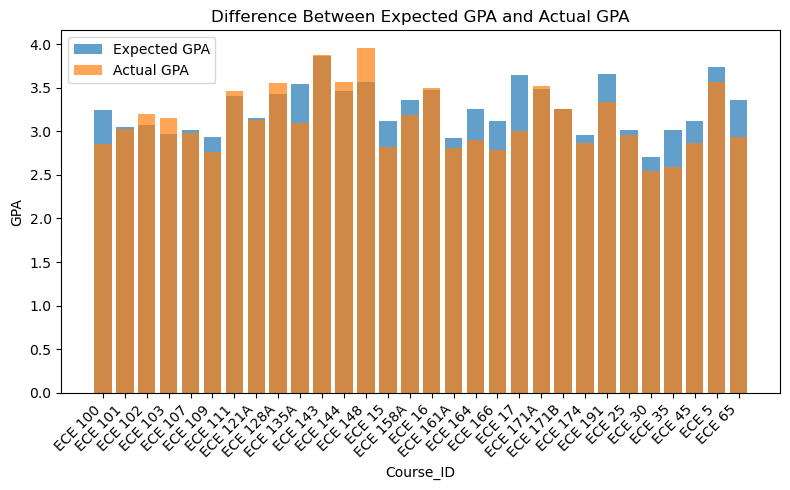

In [22]:
grade_dev_draw = grade_dev_factor_depart  

plt.figure(figsize=(8, 5))

plt.bar(grade_dev_draw['Course_ID'], grade_dev_draw['expected_gpa'], label='Expected GPA', alpha=0.7)
plt.bar(grade_dev_draw['Course_ID'], grade_dev_draw['actual_gpa'], label='Actual GPA', alpha=0.7)


plt.title('Difference Between Expected GPA and Actual GPA')
plt.xlabel('Course_ID')
plt.ylabel('GPA')


plt.xticks(rotation=45, ha='right')

plt.legend()

plt.tight_layout()
plt.show()

In [23]:
# factor 3: gpa got
grade_factor_depart = grade_dev_factor_depart[['actual_gpa']].copy()
print(grade_factor_depart)

    actual_gpa
0         2.85
1         3.03
2         3.20
3         3.15
4         2.98
5         2.76
6         3.46
7         3.13
8         3.55
9         3.10
10        3.87
11        3.56
12        3.96
13        2.82
14        3.19
15        3.50
16        2.81
17        2.90
18        2.78
19        3.00
20        3.52
21        3.26
22        2.87
23        3.34
24        2.96
25        2.55
26        2.59
27        2.87
28        3.57
29        2.94


In [24]:
# gpa plot will not be plotted since it is included in the gpa difference figure. We simply add it as a weight for our recommendation system

In [25]:
# factor 4: % recommend the class
class_factor = get_class_rmd_df(df_quarter)
class_factor_depart = class_factor[class_factor['Course_ID'].str.contains('ECE')].copy().reset_index(drop=True)
print(class_factor_depart)

   Course_ID  rmd_class
0    ECE 100      90.85
1    ECE 101      89.05
2    ECE 102      95.25
3    ECE 103      81.87
4    ECE 107      74.88
5    ECE 109      76.95
6    ECE 111      71.55
7   ECE 121A      92.20
8   ECE 128A      90.62
9   ECE 135A      95.85
10   ECE 143      95.15
11   ECE 144      93.45
12   ECE 148      85.70
13    ECE 15      77.45
14  ECE 158A      90.10
15    ECE 16      91.23
16  ECE 161A      80.58
17   ECE 164      92.08
18   ECE 166      93.28
19    ECE 17      89.80
20  ECE 171A      97.75
21  ECE 171B      93.72
22   ECE 174      83.70
23   ECE 191      87.50
24    ECE 25      77.80
25    ECE 30      65.80
26    ECE 35      88.76
27    ECE 45      76.35
28     ECE 5      97.67
29    ECE 65      93.75


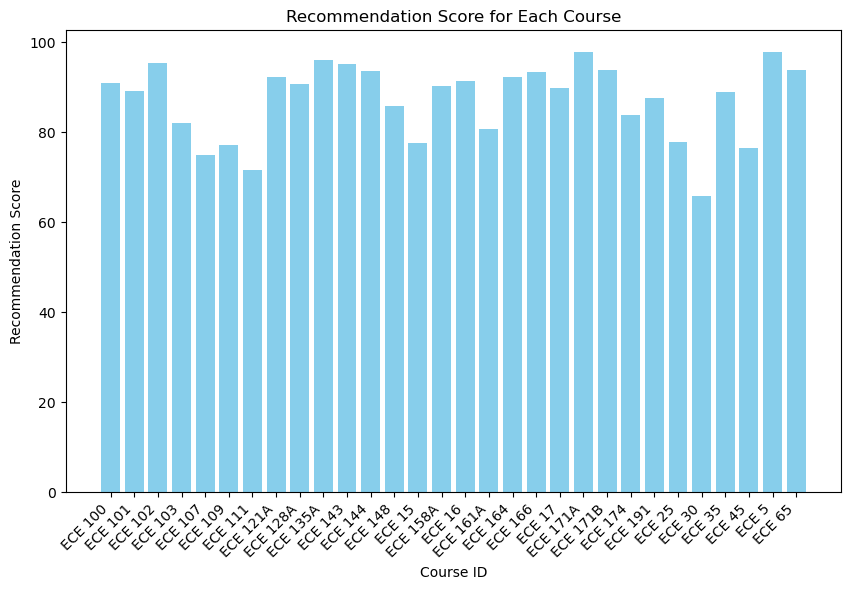

In [26]:
plt.figure(figsize=(10, 6))

plt.bar(class_factor_depart['Course_ID'], class_factor_depart['rmd_class'], color='skyblue')

plt.xlabel('Course ID')
plt.ylabel('Recommendation Score')
plt.title('Recommendation Score for Each Course')

plt.xticks(rotation=45, ha='right')

plt.show()

In [27]:
# factor 5: % recommend the instructor
instr_factor = get_instr_rmd_df(df_quarter)
instr_factor_depart = instr_factor[instr_factor['Course_ID'].str.contains('ECE')].copy().reset_index(drop=True)
print(instr_factor_depart)

   Course_ID                       instr  rmd_instr
0    ECE 100        Baghdadchi, Saharnaz      95.70
1    ECE 100      Sievenpiper, Daniel F.      86.23
2    ECE 101             Siegel, Paul H.      95.28
3    ECE 102            Hsueh, Tzu-Chien      95.20
4    ECE 103                 Ng, Tse Nga      85.40
5    ECE 107            Lomakin, Vitaliy      78.18
6    ECE 109    Fazeli Chaghooshi, Arman      78.50
7    ECE 109           Zeger, Kenneth A.      78.33
8    ECE 111               Karna, Vishal      81.80
9    ECE 111         Koushanfar, Farinaz      66.27
10  ECE 121A         Esmaili, Gholamreza      88.02
11  ECE 128A  Abi Samra, Nicholas Camill      95.83
12  ECE 128A         Esmaili, Gholamreza      84.20
13  ECE 135A                Kuzum, Duygu     100.00
14   ECE 143           Unpingco, Jose H.      96.58
15   ECE 144       Phan, Alex Minh Giang      91.10
16   ECE 148             Silberman, Jack      71.40
17    ECE 15             Schurgers, Curt      88.07
18    ECE 15

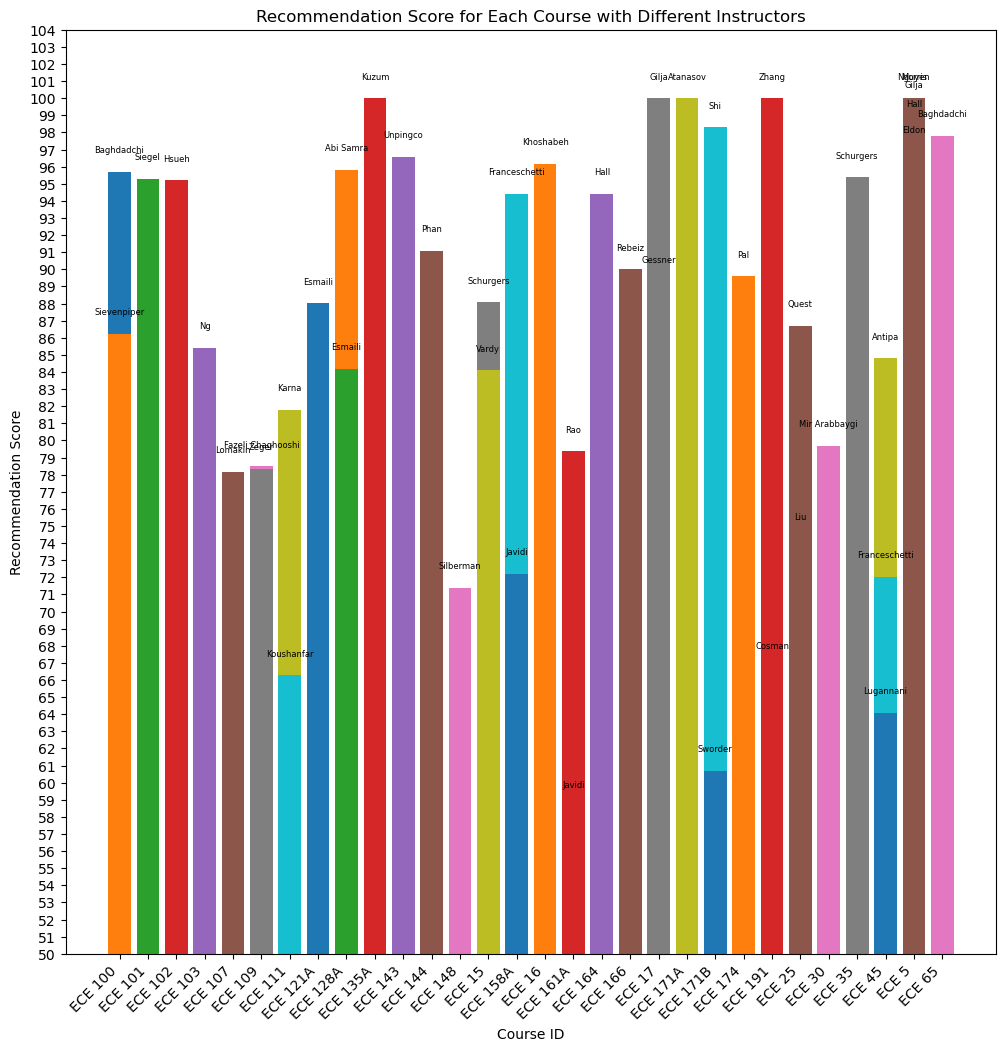

In [36]:
plt.figure(figsize=(12, 12))
for i, course_id in enumerate(instr_factor_depart['Course_ID']):
    plt.bar(course_id, instr_factor_depart['rmd_instr'].iloc[i], label=instr_factor_depart['instr'].iloc[i].split(',')[0])
    plt.text(course_id, instr_factor_depart['rmd_instr'].iloc[i] + 1, instr_factor_depart['instr'].iloc[i].split(',')[0], ha='center', va='bottom', fontsize=6)

plt.xlabel('Course ID')
plt.ylabel('Recommendation Score')
plt.title('Recommendation Score for Each Course with Different Instructors')
plt.xticks(rotation=45, ha='right')
plt.ylim(50, 100)
plt.yticks(range(50, 105))  # 如果需要更详细的刻度，可以自定义刻度

plt.show()

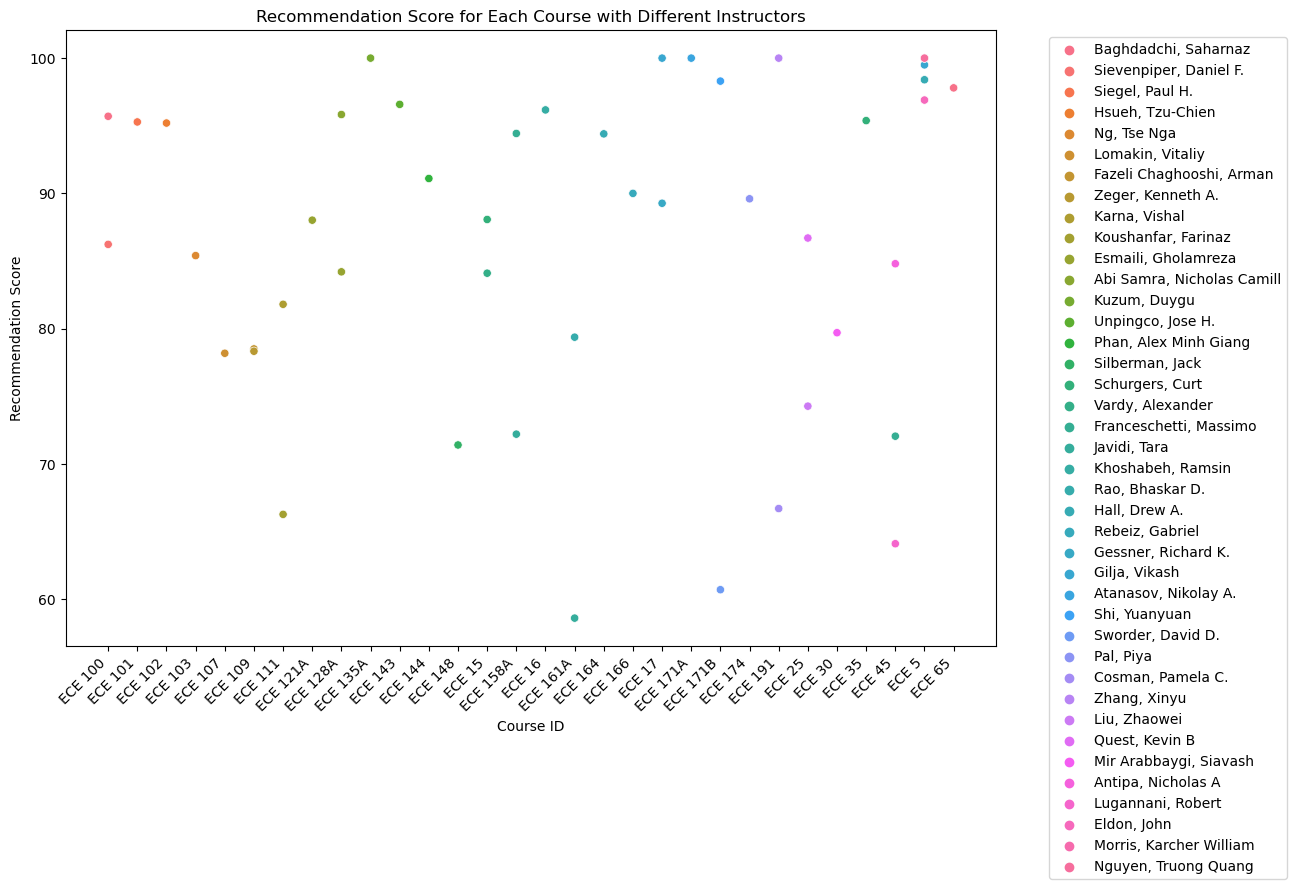

In [29]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x='Course_ID', y='rmd_instr', hue='instr', data=instr_factor_depart)
plt.xlabel('Course ID')
plt.ylabel('Recommendation Score')
plt.title('Recommendation Score for Each Course with Different Instructors')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.show()